# Summary of basillus subtilus series on NCBI

In [163]:
import pandas as pd

results = []
with open('basillus_summary.txt', 'rb') as f:
    items = f.read().decode('utf-8').split("\r\n\r\n") 
    
for item in items:
    result = {}
    item = item.split("\r\n")
    result["title"] = item[0]
    result["submitter_supplied"] = item[1].replace("(Submitter supplied) ", "")
    result["organisms"] = item[2].split("\t")[1]
    result["type"] = item[3].split("\t")[2]
    result["samples"] = int(item[4].split()[-2])
    
    if "SRA" in item[6]:
        result["series_accession"] = item[7].split()[2]
        result["series_id"] = item[7].split()[4]
    else:
        result["series_accession"] = item[6].split()[2]
        result["series_id"] = item[6].split()[4]
    results.append(result) 
df = pd.DataFrame(data=results)         

In [164]:
df

,organisms,samples,series_accession,series_id,submitter_supplied,title,type
0,Staphylococcus aureus; Bacillus subtilis,16,GSE108295,200108295,Endonucleolytic cleavage within polycistronic ...,1. Maturation of polycistronic mRNA by RNase Y...,Other
1,Vibrio natriegens NBRC 15636 = ATCC 14048 = DS...,21,GSE95211,200095211,Coexpression of proteins in response to pathwa...,2. Evolutionary Convergence of Pathway-specifi...,Other
2,Bacillus subtilis,9,GSE111577,200111577,The cold shock response of B. subtilis was def...,3. The cold shock response of Bacillus subtili...,Expression profiling by high throughput sequen...
3,Bacillus amyloliquefaciens; Bacillus subtilis,112,GSE108659,200108659,The transcriptome of 8 strains were studied du...,4. Analysis of differential gene expression du...,Expression profiling by high throughput sequen...
4,Pseudomonas aeruginosa; Bacillus subtilis; Can...,18,GSE106133,200106133,RNAs are well-suited to act as cellular sensor...,5. Genome-wide identification of natural RNA a...,Expression profiling by high throughput sequen...
5,Escherichia coli; Bacillus subtilis subsp. sub...,58,GSE84421,200084421,The objective of the study was to determine th...,6. Expression profiles of Bacillus subtilis st...,Expression profiling by array
6,Caenorhabditis elegans,13,GSE95636,200095636,Young adult N2 Caenorhabditis elegans were inf...,7. Caenorhabditis elegans infected with Entero...,Expression profiling by array
7,Bacillus subtilis,5,GSE94788,200094788,The cell division protein SepF aligns polymers...,8. Free SepF blocks recruitment of late cell d...,Expression profiling by array
8,Bacillus subtilis,12,GSE104816,200104816,With these experiments we investigate the impa...,9. Transcriptional profiling of Bacillus subti...,Expression profiling by high throughput sequen...
9,Geobacillus stearothermophilus; Bacillus subti...,23,GSE98874,200098874,CCA-adding enzymes are highly specific RNA pol...,10. Cold adaptation of tRNA nucleotidyltransfe...,Expression profiling by high throughput sequen...


In [165]:
import itertools

#leave out experiments which have more than 1 organism and sort by samples
df = df[~df['organisms'].str.contains(";") & df['organisms'].str.contains("Bacillus subtilis")].sort_values("samples", ascending=False)

#make a list of the accessions to use with GEOparse
accessions_list = list(itertools.chain(*df[['series_accession']].values.tolist()))

In [166]:
import urllib.request
import os.path


def download_soft(experiment):
    fname = 'data/'+experiment+'_family.soft.gz'
    if not os.path.isfile(fname):
        urllib.request.urlretrieve('https://ftp.ncbi.nlm.nih.gov/geo/series/'+experiment[:-3]+'nnn/'+experiment+'/soft/'+experiment+'_family.soft.gz', fname)
    
#Download all SOFT files
#takes some time..
#~330 MB
for ex in accessions_list:
    download_soft(ex)

In [167]:
import GEOparse
import random

GEOparse.set_verbosity('ERROR')

def read_experiment(experiment):
    return GEOparse.get_GEO(filepath="data/" + experiment + "_family.soft.gz")


def get_extra_columns(gsm, ex):
    #find column description of random sample
    extra_column = {}
    extra_column["series_accession"] = ex
    values = gsm.gsms[list(gsm.gsms)[0]].columns['description'].values
    if len(values) == 0:
        extra_column["value_description"] = ""
    else:
        extra_column["value_description"] = gsm.gsms[list(gsm.gsms)[0]].columns['description'].values[1]
    values = pd.Series(gsm.gsms[list(gsm.gsms)[0]].table["VALUE"])
    extra_column["count"] = values.count()
    extra_column["mean"] = values.mean()
    extra_column["standard_deviation"] = values.std()
    return extra_column

#this takes some time...
extra_columns = []
for ex in accessions_list:
    try:
        gsm = read_experiment(ex)
        extra_column = get_extra_columns(gsm, ex)
    except:
        extra_column = {}
    extra_columns.append(extra_column)
    

df_extra = pd.DataFrame(extra_columns)
df = df.join(df_extra.set_index('series_accession'), on="series_accession")

C:\Users\pim_d\Anaconda3\lib\site-packages\GEOparse\GEOparse.py:332: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  return DataFrame.from_csv(StringIO(data), index_col=None, sep="\t")


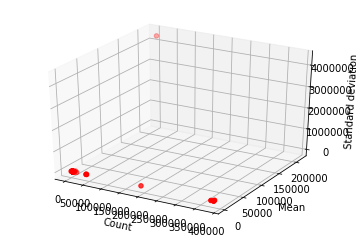

In [168]:
#make a scatter plot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def make_scatter_plot(df):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x =df["count"].dropna()
    y =df["mean"].dropna()
    z =df["standard_deviation"].dropna()
    
    ax.scatter(x, y, z, c='r', marker='o')
    ax.set_xlabel('Count')
    ax.set_ylabel('Mean')
    ax.set_zlabel('Standard deviation')

    plt.show()

make_scatter_plot(df)

In [169]:
df["mean"].nlargest(10)

72     214261.666875
103      3151.249089
184      2439.243871
172      1264.448442
186      1208.866660
74        851.843368
69        374.822666
205       125.723708
94         11.067329
20         10.612957
Name: mean, dtype: float64

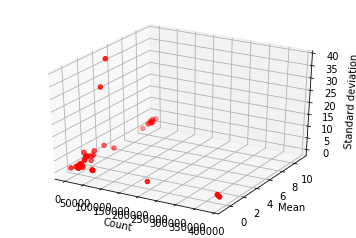

In [170]:
df_smaller = df.drop(df["mean"].nlargest(8).index).dropna()
make_scatter_plot(df_smaller)

In [171]:
df_smaller["count"].nlargest(10)

130    383238.0
112    383148.0
185    376000.0
65     191618.0
11      43735.0
126     41882.0
162     41882.0
144     41882.0
149     41882.0
178     15744.0
Name: count, dtype: float64

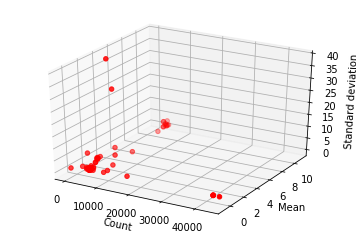

In [172]:
df_smaller = df_smaller.drop(df_smaller["count"].nlargest(4).index).dropna()
make_scatter_plot(df_smaller)

In [173]:
df_smaller["standard_deviation"].nlargest(10)

129    38.105229
183    28.298867
202     5.077650
114     4.050304
140     3.677663
213     3.502958
24      3.434114
7       3.157749
20      3.153380
199     2.978655
Name: standard_deviation, dtype: float64

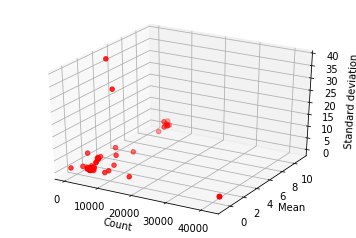

In [174]:
df_smaller = df_smaller.drop(df_smaller["count"].nlargest(2).index).dropna()
make_scatter_plot(df_smaller)

Estimated number of clusters: 9


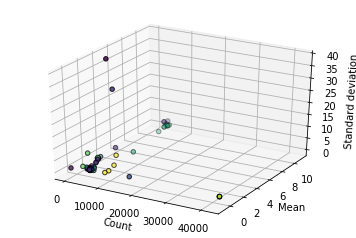

In [175]:
from sklearn.cluster import AffinityPropagation

AP = AffinityPropagation()
train = df_smaller[['count','mean', 'standard_deviation']].dropna().values

AP.fit(train)
cluster_centers_indices = AP.cluster_centers_indices_
cluster_centers_indices = AP.cluster_centers_indices_
labels = AP.labels_

n_clusters = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters)

from sklearn.cluster import KMeans
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = train[:, 0]
y = train[:, 1]
z = train[:, 2]



ax.scatter(x, y, z, c=labels.astype(np.float), edgecolor='k', marker='o')

ax.set_xlabel('Count')
ax.set_ylabel('Mean')
ax.set_zlabel('Standard deviation')

plt.show()